<a href="https://colab.research.google.com/github/balandongiv/mmocr_tutorial/blob/main/custom%20mmocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMOCR Tutorial

Welcome to MMOCR! This is the **unofficial** colab tutorial for using MMOCR. In this tutorial, you will learn how to

- Transform annotation in coco-like json format to MMOCR compatible format.
- Set custom configuration file
- Integrate mmocr config template extracted from `base` with user custom setting (Not sure if this is possible? or how to achieve:KIV)
- Train a text recognizer with a toy dataset. 

Authors: Rodney Petrus Balandong balandongiv@gmail.com

# Install MMOCR

When installing dependencies for mmocr, please ensure that all the dependency versions are compatible with each other. For instance, if CUDA 10.1 is installed, then the Pytorch version must be compatible with cu10.1. Please see [getting_started.md](docs/getting_started.md) for more details. 

In [1]:
%cd ..

/


### Check PyTorch version

In [2]:
!pip show torch

Name: torch
Version: 1.11.0+cu113
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.7/dist-packages
Requires: typing-extensions
Required-by: torchvision, torchtext, torchaudio, fastai


### Install Dependencies 

In [ ]:
# Install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.11.0/index.html

# Install mmdetection
!pip install mmdet

# # Install mmocr
!git clone https://github.com/open-mmlab/mmocr.git
%cd mmocr
!pip install -r requirements.txt
!pip install -v -e .

### Check Installed Dependencies Versions

In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
import mmcv
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(mmcv.__version__)
print(get_compiling_cuda_version())
print(get_compiler_version())

# Check mmocr installation
import mmocr
print(mmocr.__version__)

%cd /mmocr/
!ls

#Perform Training on a Toy Dataset with MMOCR Recognizer
We now demonstrate how to perform training with an MMOCR recognizer. Since training a full academic dataset is time consuming (usually takes about several hours), we will train on the toy dataset for the SAR text recognition model and visualize the predictions.

Training a dataset usually consists of the following steps:
1. Convert the dataset into a format supported by MMOCR (e.g. COCO for text detection). The annotation file can be in either .txt or .lmdb format, depending on the size of the dataset. This step is usually applicable to customized datasets, since the datasets and annotation files we provide are already in supported formats. 
2. Modify the config for training. 
3. Train the model. 



## About the Toy Dataset

In this tutorial, we will be working with the dataset under the folder `toy_dataset`. 

Each of the image have the accompnying `annotation` file generated using the `labelme`

The images were stored under the following path

`/mmocr/tests/data/toy_dataset/imgs/test`

The annotation were stored under  the following path

`/mmocr/tests/data/toy_dataset/labelme`




In [ ]:
# Print list of images and annotation available under the`toy_dataset` folder
!cat /mmocr/tests/data/toy_dataset/img_list.txt

We first get a sense of what the toy dataset looks like by visualizing one of the images and labels. 

In [ ]:
import mmcv
import matplotlib.pyplot as plt 

#To ensure we are in the root directory
%cd .. 

img = mmcv.imread('/mmocr/tests/data/toy_dataset/imgs/test/img_1.jpg')

plt.imshow(mmcv.bgr2rgb(img))
plt.show()

Let visualise the annotation

In [ ]:
!cat /mmocr/tests/data/toy_dataset/labelme/img_1.json

## Prepare Annotation to MMOCR format 

Since the annotations are in COCO format, we need to firstly convert annotation in labelme format to MMOCR's annotation format using the `labelme_converter.py`.

For this particular example, we will convert the labelme format annotation in `/mmocr/tests/data/toy_dataset/labelme` to MMOCR detection labels instances_training `.txt` and export the cropped image patches for recognition task to `/mmocr/tests/data/toy_dataset/crops`. It is worth to note that the following setting would not output the `test_label.txt` as there is no test set. This information is important  when assigning  `test_anno_file1` to `train_label.txt` in subsequent step.

In Google colab, it is essential to add a `!` before the Python command.


For this particular dataset, preferable to use the `.jsonl` as the annotation output

In [16]:
!python /mmocr/tools/data/common/labelme_converter.py /mmocr/tests/data/toy_dataset/labelme /mmocr/tests/data/toy_dataset/imgs/test /mmocr/tests/data/toy_dataset --tasks recog --format jsonl

[>>] 10/10, 92.8 task/s, elapsed: 0s, ETA:     0s
finish


Let have a look what files has been generated from the previous calling

In [17]:
# List of crop images that being crop in accordance to the bounding box
import os
root = '/mmocr/tests/data/toy_dataset' # Location where the annotation and crop images are being stored
path_crop_img=os.path.join(root,'crops')
print([os.path.join(path, name) for path, subdirs, files in os.walk(path_crop_img) for name in files])

['/mmocr/tests/data/toy_dataset/crops/img_6/crop_1.jpg', '/mmocr/tests/data/toy_dataset/crops/img_6/crop_0.jpg', '/mmocr/tests/data/toy_dataset/crops/img_8/crop_3.jpg', '/mmocr/tests/data/toy_dataset/crops/img_8/crop_1.jpg', '/mmocr/tests/data/toy_dataset/crops/img_8/crop_0.jpg', '/mmocr/tests/data/toy_dataset/crops/img_8/crop_2.jpg', '/mmocr/tests/data/toy_dataset/crops/img_10/crop_1.jpg', '/mmocr/tests/data/toy_dataset/crops/img_10/crop_0.jpg', '/mmocr/tests/data/toy_dataset/crops/img_10/crop_2.jpg', '/mmocr/tests/data/toy_dataset/crops/img_1/crop_3.jpg', '/mmocr/tests/data/toy_dataset/crops/img_1/crop_1.jpg', '/mmocr/tests/data/toy_dataset/crops/img_1/crop_0.jpg', '/mmocr/tests/data/toy_dataset/crops/img_1/crop_2.jpg', '/mmocr/tests/data/toy_dataset/crops/img_7/crop_1.jpg', '/mmocr/tests/data/toy_dataset/crops/img_7/crop_0.jpg', '/mmocr/tests/data/toy_dataset/crops/img_2/crop_1.jpg', '/mmocr/tests/data/toy_dataset/crops/img_2/crop_0.jpg', '/mmocr/tests/data/toy_dataset/crops/img_3/c

Lets visualise the MMOCR detection labels instances_training `.jsonl`

In [18]:
!cat /mmocr/tests/data/toy_dataset/train_label.jsonl

{"filename": "/mmocr/tests/data/toy_dataset/crops/img_9/crop_0.jpg", "text": "EXIT"}
{"filename": "/mmocr/tests/data/toy_dataset/crops/img_9/crop_1.jpg", "text": "STAGE"}
{"filename": "/mmocr/tests/data/toy_dataset/crops/img_6/crop_0.jpg", "text": "Reserve"}
{"filename": "/mmocr/tests/data/toy_dataset/crops/img_6/crop_1.jpg", "text": "CAUTION"}
{"filename": "/mmocr/tests/data/toy_dataset/crops/img_10/crop_0.jpg", "text": "HarbourFront"}
{"filename": "/mmocr/tests/data/toy_dataset/crops/img_10/crop_1.jpg", "text": "CC22"}
{"filename": "/mmocr/tests/data/toy_dataset/crops/img_10/crop_2.jpg", "text": "bua"}
{"filename": "/mmocr/tests/data/toy_dataset/crops/img_2/crop_0.jpg", "text": "EXIT"}
{"filename": "/mmocr/tests/data/toy_dataset/crops/img_2/crop_1.jpg", "text": "I2R"}
{"filename": "/mmocr/tests/data/toy_dataset/crops/img_3/crop_0.jpg", "text": "fusionopolis"}
{"filename": "/mmocr/tests/data/toy_dataset/crops/img_3/crop_1.jpg", "text": "fusionopolis"}
{"filename": "/mmocr/tests/data/t

## Configuration file

The MMOCR's config system incorporate modular and inheritance design, which is convenient to conduct various experiments. 

**REMARK**
The modular code in each cell is for explaination purpose, toward the end, the code will be paste in a `.py` file.


The config file structure consist on the parameter `model`, `data & pipeline`, `training schedule`, and `runtime setting`. Please refer to [config file structure](https://mmocr.readthedocs.io/en/latest/tutorials/config.html#config-file-structure) for detailed documentation

Firstly, We can import predefine configurations as follow



```
_base_ = [
    '/mmocr/configs/_base_/default_runtime.py',
    '/mmocr/configs/_base_/recog_models/sar.py',
    '/mmocr/configs/_base_/schedules/schedule_adam_step_5e.py',
    '/mmocr/configs/_base_/recog_pipelines/sar_pipeline.py',
]
```
The pipeline can be assigned as 



```
train_pipeline = {{_base_.train_pipeline}}
test_pipeline = {{_base_.test_pipeline}}
```



Define the training and validation datasets

```

dataset_type = 'OCRDataset'
root = '/mmocr/tests/data/toy_dataset' # Location where the annotation and crop images are being stored

img_prefix ='/mmocr/tests/data/toy_dataset/crops'
train_anno_file1 = '/mmocr/tests/data/toy_dataset/train_label.jsonl'
test_anno_file1 = '/mmocr/tests/data/toy_dataset/train_label.jsonl'

# Set up working dir to save files and logs.
work_dir = '/mmocr/demo/tutorial_exps'



loader_dt_train = dict(type='AnnFileLoader',
                            repeat=1,                   
                            file_format='txt',  # only txt and lmdb
                            file_storage_backend='disk',
                            parser=dict(type='LineJsonParser',
                                        keys=['filename', 'text']))

loader_dt_test = dict(type = 'AnnFileLoader',
                        repeat = 1,
                        file_format = 'txt',  # only txt and lmdb
                        file_storage_backend = 'disk',
                        parser = dict(type = 'LineJsonParser',
                                    keys = ['filename', 'text']))


train_datasets1 = dict(type='OCRDataset',
                       img_prefix=img_prefix,
                       ann_file=train_anno_file1,
                       loader=loader_dt_train,
                       pipeline=None,           
                       test_mode=False)




# For time being, assume the setting for training and validation is the same
val_dataset = dict(type='OCRDataset',
                   img_prefix=img_prefix,
                   ann_file=test_anno_file1,
                   loader=loader_dt_test,
                   pipeline=None,              
                   test_mode=True)


train_list = [train_datasets1]
test_list = [val_dataset]


```
It is also possible to have multiple dataset

For example

```
train_list = [train_datasets1,train_datasets2,train_datasets3]
test_list = [val_dataset,val_dataset2]
```

Finally, assign all the informations into the `data` dictionary

```
data = dict(
    samples_per_gpu=64,
    workers_per_gpu=4,
    val_dataloader=dict(samples_per_gpu=1),
    test_dataloader=dict(samples_per_gpu=1),
    train=dict(
        type='UniformConcatDataset',
        datasets=train_list,
        pipeline=train_pipeline),
    val=dict(
        type='UniformConcatDataset',
        datasets=test_list,
        pipeline=test_pipeline),
    test=dict(
        type='UniformConcatDataset',
        datasets=test_list,
        pipeline=test_pipeline))


evaluation = dict(interval=1, metric='acc')

cudnn_benchmark = True
```

As mentioned, this `cfg` need to be stored in a `.py` file.

Please refer this [tutorial](https://stackoverflow.com/a/58228374/6446053) on how to create a file in Google Colab.

First create a `my_cfg.py` file at `/content/my_cfg.py`

Then, copy and paste the following lines

**REMARK** 

PLEASE DO NOT EXECUTE THE FOLLOWING CELL

In [ ]:
_base_ = [
    '/mmocr/configs/_base_/default_runtime.py',
    '/mmocr/configs/_base_/recog_models/sar.py',
    '/mmocr/configs/_base_/schedules/schedule_adam_step_5e.py',
    '/mmocr/configs/_base_/recog_pipelines/sar_pipeline.py',
]

train_pipeline = {{_base_.train_pipeline}}
test_pipeline = {{_base_.test_pipeline}}

dataset_type = 'OCRDataset'
root = '/mmocr/tests/data/toy_dataset' # Location where the annotation and crop images are being stored

img_prefix ='/mmocr/tests/data/toy_dataset/crops'
train_anno_file1 = '/mmocr/tests/data/toy_dataset/train_label.jsonl'
test_anno_file1 = '/mmocr/tests/data/toy_dataset/train_label.jsonl'

# Set up working dir to save files and logs.
work_dir = '/mmocr/demo/tutorial_exps'



loader_dt_train = dict(type='AnnFileLoader',
                            repeat=1,                   
                            file_format='txt',  # only txt and lmdb
                            file_storage_backend='disk',
                            parser=dict(type='LineJsonParser',
                                        keys=['filename', 'text']))

loader_dt_test = dict(type = 'AnnFileLoader',
                        repeat = 1,
                        file_format = 'txt',  # only txt and lmdb
                        file_storage_backend = 'disk',
                        parser = dict(type = 'LineJsonParser',
                                    keys = ['filename', 'text']))


train_datasets1 = dict(type='OCRDataset',
                       img_prefix=img_prefix,
                       ann_file=train_anno_file1,
                       loader=loader_dt_train,
                       pipeline=None,           
                       test_mode=False)




# For time being, assume the setting for training and validation is the same
val_dataset = dict(type='OCRDataset',
                   img_prefix=img_prefix,
                   ann_file=test_anno_file1,
                   loader=loader_dt_test,
                   pipeline=None,              
                   test_mode=True)


train_list = [train_datasets1]
test_list = [val_dataset]


data = dict(
    samples_per_gpu=64,
    workers_per_gpu=4,
    val_dataloader=dict(samples_per_gpu=1),
    test_dataloader=dict(samples_per_gpu=1),
    train=dict(
        type='UniformConcatDataset',
        datasets=train_list,
        pipeline=train_pipeline),
    val=dict(
        type='UniformConcatDataset',
        datasets=test_list,
        pipeline=test_pipeline),
    test=dict(
        type='UniformConcatDataset',
        datasets=test_list,
        pipeline=test_pipeline))


evaluation = dict(interval=1, metric='acc')

cudnn_benchmark = True


gpu_ids = range(1)

In order to perform inference for SAR on colab, we need to adjust the config values to accommodate some of the settings of colab such as the number of GPU available. 

In [ ]:
from mmdet.apis import set_random_seed


# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.

optimizer = dict(type = 'Adam', 
                 lr = 0.001 / 8)


lr_config = dict(policy = 'step', 
                 step = [3, 4], 
                 warmup = None  # Set warmup to None when work in Colab
                 ) 


log_config = dict(
                  interval = 40,  # Choose to log training results every 40 images to reduce the size of log file. 
                  hooks = [dict(type = 'TextLoggerHook')])

# Set seed thus the results are more reproducible
seed = 0
set_random_seed(0, deterministic=False)
gpu_ids = range(1)


Lets create the configration file

In [24]:
from mmcv import Config

cfg = Config.fromfile('/content/my_cfg.py')

## Train the SAR Text Recognizer 
Finally, we train the SAR text recognizer on the toy dataset for five epochs. 

This steps took about ~ 5 minutes to complete or <15 if Colab is connected with GPU 


In [26]:
from mmdet.apis import set_random_seed
from mmocr.datasets import build_dataset
from mmocr.models import build_detector
from mmocr.apis import train_detector
import os.path as osp

seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let also limit the training to only 5 epochs

cfg.runner = dict(type='EpochBasedRunner', max_epochs=6) # Default max_epochs is 1200

#save the model every 5 epoch
cfg.checkpoint_config = dict(interval=2) # Default the interval was set to 100

print(f'Config:\n{cfg.pretty_text}')

# Build dataset
datasets = [build_dataset(cfg.data.train)]
#
# # Build the detector
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
#
# # Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# # Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

Exception ignored in: <function _TemporaryFileCloser.__del__ at 0x7fcb172034d0>
Traceback (most recent call last):
  File "/usr/lib/python3.7/tempfile.py", line 587, in __del__
    self.close()
  File "/usr/lib/python3.7/tempfile.py", line 583, in close
    unlink(self.name)
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpqopwvy_2/tmpy9yqt40e.py'


Config:
log_config = dict(interval=5, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = None
resume_from = None
workflow = [('train', 1)]
opencv_num_threads = 0
mp_start_method = 'fork'
label_convertor = dict(
    type='AttnConvertor', dict_type='DICT90', with_unknown=True)
model = dict(
    type='SARNet',
    backbone=dict(type='ResNet31OCR'),
    encoder=dict(
        type='SAREncoder', enc_bi_rnn=False, enc_do_rnn=0.1, enc_gru=False),
    decoder=dict(
        type='ParallelSARDecoder',
        enc_bi_rnn=False,
        dec_bi_rnn=False,
        dec_do_rnn=0,
        dec_gru=False,
        pred_dropout=0.1,
        d_k=512,
        pred_concat=True),
    loss=dict(type='SARLoss'),
    label_convertor=dict(
        type='AttnConvertor', dict_type='DICT90', with_unknown=True),
    max_seq_len=30)
optimizer = dict(type='Adam', lr=0.001)
optimizer_config = dict(grad_clip=None)
lr_config = dict(policy='step', step=[3, 4])
runner = dict

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
2022-06-24 13:57:20,717 - mmocr - INFO - Start running, host: root@d2b4cf609006, work_dir: /mmocr/demo/tutorial_exps
2022-06-24 13:57:20,718 - mmocr - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook      

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 21/21, 9.0 task/s, elapsed: 2s, ETA:     0s

2022-06-24 13:57:26,590 - mmocr - INFO - 
Evaluating /mmocr/tests/data/toy_dataset/train_label.jsonl with 21 images now
2022-06-24 13:57:26,598 - mmocr - INFO - Epoch(val) [1][21]	0_char_recall: 0.1613, 0_char_precision: 0.0317, 0_word_acc: 0.0000, 0_word_acc_ignore_case: 0.0000, 0_word_acc_ignore_case_symbol: 0.0000, 0_1-N.E.D: 0.0286
2022-06-24 13:57:29,692 - mmocr - INFO - Saving checkpoint at 2 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 21/21, 8.4 task/s, elapsed: 3s, ETA:     0s

2022-06-24 13:57:37,040 - mmocr - INFO - 
Evaluating /mmocr/tests/data/toy_dataset/train_label.jsonl with 21 images now
2022-06-24 13:57:37,043 - mmocr - INFO - Epoch(val) [2][21]	0_char_recall: 0.0000, 0_char_precision: 0.0000, 0_word_acc: 0.0000, 0_word_acc_ignore_case: 0.0000, 0_word_acc_ignore_case_symbol: 0.0000, 0_1-N.E.D: 0.0000


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 21/21, 8.7 task/s, elapsed: 2s, ETA:     0s

2022-06-24 13:57:42,822 - mmocr - INFO - 
Evaluating /mmocr/tests/data/toy_dataset/train_label.jsonl with 21 images now
2022-06-24 13:57:42,828 - mmocr - INFO - Epoch(val) [3][21]	0_char_recall: 0.0000, 0_char_precision: 0.0000, 0_word_acc: 0.0000, 0_word_acc_ignore_case: 0.0000, 0_word_acc_ignore_case_symbol: 0.0000, 0_1-N.E.D: 0.0000
2022-06-24 13:57:46,038 - mmocr - INFO - Saving checkpoint at 4 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 21/21, 8.3 task/s, elapsed: 3s, ETA:     0s

2022-06-24 13:57:52,952 - mmocr - INFO - 
Evaluating /mmocr/tests/data/toy_dataset/train_label.jsonl with 21 images now
2022-06-24 13:57:52,955 - mmocr - INFO - Epoch(val) [4][21]	0_char_recall: 0.0000, 0_char_precision: 0.0000, 0_word_acc: 0.0000, 0_word_acc_ignore_case: 0.0000, 0_word_acc_ignore_case_symbol: 0.0000, 0_1-N.E.D: 0.0000


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 21/21, 8.7 task/s, elapsed: 2s, ETA:     0s

2022-06-24 13:57:58,733 - mmocr - INFO - 
Evaluating /mmocr/tests/data/toy_dataset/train_label.jsonl with 21 images now
2022-06-24 13:57:58,738 - mmocr - INFO - Epoch(val) [5][21]	0_char_recall: 0.0000, 0_char_precision: 0.0000, 0_word_acc: 0.0000, 0_word_acc_ignore_case: 0.0000, 0_word_acc_ignore_case_symbol: 0.0000, 0_1-N.E.D: 0.0000
2022-06-24 13:58:01,966 - mmocr - INFO - Saving checkpoint at 6 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 21/21, 8.3 task/s, elapsed: 3s, ETA:     0s

2022-06-24 13:58:08,876 - mmocr - INFO - 
Evaluating /mmocr/tests/data/toy_dataset/train_label.jsonl with 21 images now
2022-06-24 13:58:08,883 - mmocr - INFO - Epoch(val) [6][21]	0_char_recall: 0.0000, 0_char_precision: 0.0000, 0_word_acc: 0.0000, 0_word_acc_ignore_case: 0.0000, 0_word_acc_ignore_case_symbol: 0.0000, 0_1-N.E.D: 0.0000


## Test and Visualize the Predictions

For completeness, we also perform testing on the latest checkpoint and evaluate the results with hmean-iou metrics. The predictions are saved in the ./outputs file. 

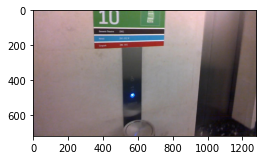

In [ ]:
# Visualize the testing image.
img='/mmocr/tests/data/toy_dataset/imgs/test/img_1.jpg' # This should be an overfit, since we testing an image that has been used for training!

_img = mmcv.imread(img)
plt.figure(figsize=(4, 4))
plt.imshow(mmcv.bgr2rgb(_img))
plt.show()

In [ ]:
print(cfg.work_dir)

/mmocr/demo/tutorial_exps


In [ ]:
from mmocr.apis import init_detector, model_inference


img='/mmocr/tests/data/toy_dataset/imgs/test/img_1.jpg'  # This should be an overfit, since we testing an image that has been used for training!



checkpoint=os.path.join(cfg.work_dir,'epoch_5.pth')


out_file = 'outputs/1036169s.jpg'   # Rendered image save location

model = init_detector(cfg, checkpoint, device="cuda:0")
if model.cfg.data.test['type'] == 'ConcatDataset':
    model.cfg.data.test.pipeline = model.cfg.data.test['datasets'][0].pipeline

# Lets do inference to the image using the model that we just train.
result = model_inference(model, img)
print(f'result: {result}')

img = model.show_result(img, result, 
                        out_file=out_file, 
                        show=False)

mmcv.imwrite(img, out_file)

load checkpoint from local path: /mmocr/demo/tutorial_exps/epoch_5.pth
result: {'text': 'Nhhhhhhhhhhhhhhhhhhhhhhhhhhhhh', 'score': 0.015963149319092432}


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


True

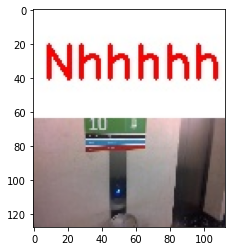

In [ ]:
# Visualize the results
predicted_img = mmcv.imread('./outputs/1036169s.jpg')
plt.figure(figsize=(4, 4))
plt.imshow(mmcv.bgr2rgb(predicted_img))
plt.show()

# Training from existing training point

### TODO

In [ ]:
# detection

!wget https://download.openmmlab.com/mmocr/textdet/textsnake/textsnake_r50_fpn_unet_1200e_ctw1500-27f65b64.pth



--2022-05-21 06:31:00--  https://download.openmmlab.com/mmocr/textdet/textsnake/textsnake_r50_fpn_unet_1200e_ctw1500-27f65b64.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145703066 (139M) [application/octet-stream]
Saving to: ‘textsnake_r50_fpn_unet_1200e_ctw1500-27f65b64.pth’

textsnake_r50_fpn_u 100%[===================>] 138.95M  7.70MB/s    in 16s     

2022-05-21 06:31:17 (8.49 MB/s) - ‘textsnake_r50_fpn_unet_1200e_ctw1500-27f65b64.pth’ saved [145703066/145703066]



In [ ]:
# recognation

!wget https://download.openmmlab.com/mmocr/textrecog/sar/sar_r31_parallel_decoder_academic-dba3a4a3.pth

--2022-05-21 06:31:28--  https://download.openmmlab.com/mmocr/textrecog/sar/sar_r31_parallel_decoder_academic-dba3a4a3.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229956710 (219M) [application/octet-stream]
Saving to: ‘sar_r31_parallel_decoder_academic-dba3a4a3.pth’

sar_r31_parallel_de 100%[===================>] 219.30M  8.73MB/s    in 27s     

2022-05-21 06:31:56 (8.23 MB/s) - ‘sar_r31_parallel_decoder_academic-dba3a4a3.pth’ saved [229956710/229956710]



In [ ]:
# %cd /mmocr/mmocr
# !ls

/mmocr/mmocr
apis  core  datasets  __init__.py  models  __pycache__	utils  version.py


In [ ]:
# from mmocr.utils.ocr import MMOCR
# mmocr = MMOCR(det='TextSnake', recog='SAR')